In [1]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 597.8 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 5.0 MB/s eta 0:00:0000:0100:01


In [2]:
! pip install super-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 1.5 MB/s eta 0:00:00eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2
import easyocr

from skimage.filters import threshold_local
from super_image import EdsrModel, ImageLoader
from PIL import Image
from ultralytics import YOLO

import re

import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [170]:
model = YOLO('/kaggle/input/yolo-second/best_Yolo8m_50epochs.pt')

In [6]:
drivers = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Drivers/Drivers'
pts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_PTS/PTS'
passports = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Passports/Passports'
sts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS'

In [459]:
album = ['udov_front', 'udov_back', 'passport_front']
book = ['pts', 'sts_front', 'sts_back', 'passport_back']

In [460]:
def yolo_predict(model, img):
    res = []
    results = model.predict(img, stream=True) 
    
    for result in results: 
        boxes = result.boxes.cpu().numpy()
        for box in boxes:
            r = box.xyxy[0].astype(int)
            class_id = int(box.cls[0])
            class_name = model.names[class_id]
            scores = box.conf[0]
            res.append((class_name, scores, r))
            
    return res

In [461]:
def crop_image(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    return cropped_image

In [462]:
def compare_white_pixels(image):
    width = image.shape[1]
    left_region = image[:, :int(width / 2)]
    right_region = image[:, int(width / 2):]

    left_white_pixels = np.sum(left_region == 255)
    right_white_pixels = np.sum(right_region == 255)
        
    return left_white_pixels > right_white_pixels

In [463]:
def rotate_to_book(image):
    height, width = image.shape[:2]
    
    if width > height:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
#     image_binary = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image_binary = cv2.GaussianBlur(image_binary,(5,5),0)
#     _, image_binary = cv2.threshold(image_binary, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     if not compare_white_pixels(image_binary):
#         image = cv2.rotate(image, cv2.ROTATE_180)
        
    return image

In [464]:
def rotate_to_album(image):
    height, width = image.shape[:2]
    
    if height > width:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
#     image_binary = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image_binary = cv2.GaussianBlur(image_binary,(5,5),0)
#     _, image_binary = cv2.threshold(image_binary, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     if not compare_white_pixels(image_binary):
#         image = cv2.rotate(image, cv2.ROTATE_180)
        
    return image

In [465]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

In [466]:
def reduce_glare(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    brightened = cv2.convertScaleAbs(blurred, alpha=1, beta=5)
    return brightened

In [467]:
def upscale(file_name, x=2):
    image = Image.open(file_name)
    model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=x).to(device)
    inputs = ImageLoader.load_image(image)
    return model(inputs)

In [468]:
def has_no_special_chars(s):
    return re.match(r'^[.%#№;:,\-\w\s]+$', s) is not None

In [469]:
check = (device.type == 'cuda')

def ocr(pic):
    reader = easyocr.Reader(['ru'], gpu=check)
    results_default = reader.readtext(pic)
    df_default = pd.DataFrame(results_default, columns=['bbox', 'text', 'conf'])
    
    flipped_pic = cv2.rotate(pic, cv2.ROTATE_180)
    reader = easyocr.Reader(['ru'], gpu=check)
    results_flipped = reader.readtext(flipped_pic)
    df_flipped = pd.DataFrame(results_flipped, columns=['bbox', 'text', 'conf'])
    ocr_ = pd.concat([df_default, df_flipped])
    
    
    df = ocr_.loc[ocr_['conf'] > 0.2]
    res = df[df['text'].apply(lambda x: len(x) > 1 and len(x) < 15 and sum(c.isalpha() for c in x) <= 2 and has_no_special_chars(x))]
    res['text'] = res['text'].apply(lambda x: re.sub(r'[!@#№$;%:^&?*()_\-+=/.,<>`~]', '', x))
    return res

In [470]:
def ocr_digits(pic):
    reader = easyocr.Reader(['ru'], gpu=check)
    results_default = reader.readtext(pic, allowlist ='0123456789')
    df_default = pd.DataFrame(results_default, columns=['bbox', 'text', 'conf'])
    
    flipped_pic = cv2.rotate(pic, cv2.ROTATE_180)
    reader = easyocr.Reader(['ru'], gpu=check)
    results_flipped = reader.readtext(flipped_pic)
    df_flipped = pd.DataFrame(results_flipped, columns=['bbox', 'text', 'conf'])
    ocr_ = pd.concat([df_default, df_flipped])
    
    df = ocr_.loc[ocr_['conf'] > 0.4]
    res = df[df['text'].apply(lambda x: len(x) > 1 and len(x) < 15 and sum(c.isalpha() for c in x) <= 2 and has_no_special_chars(x))]
    res['text'] = res['text'].apply(lambda x: re.sub(r'[!@#№$;%:^&?*()_\-+=/.,<>`~]', '', x))
    return res

In [471]:
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        texts = row['text'].split()
        if len(texts) > 1:
            for text in texts:
                new_row = row.copy()
                new_row['text'] = text
                new_rows.append(new_row)
        else:
            new_rows.append(row)
    return pd.DataFrame(new_rows)

In [472]:
def get_passport_data(df):
    filtered_rows = []
    for i in range(len(df) - 2):
        if (len(df.iloc[i]['text']) == 2 and 
            len(df.iloc[i+1]['text']) == 2 and 
            len(df.iloc[i+2]['text']) == 6 and 
            abs(df.index[i] - df.index[i+1]) <= 2 and 
            abs(df.index[i+1] - df.index[i+2]) <= 2):
            return df.iloc[i:i+3]
    return df

In [473]:
def get_vu_data(df):
    filtered_rows = []
    for i in range(len(df) - 2):
        if (len(df.iloc[i]['text']) == 2 and 
            len(df.iloc[i+1]['text']) == 2 and 
            len(df.iloc[i+2]['text']) == 6):
            return df.iloc[i:i+3]
    return df

In [474]:
def check_text(text):
    if len(text) == 10:
        return True
    return False

In [493]:
def remove_spaces(df):
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

In [519]:
def work(file_path):
    image = cv2.imread(file_path)
    predicts = yolo_predict(model, file_path)
    
    if len(predicts) == 0:
        return 'Документ не обнаружен'
    
    results = []
    
    for predict in predicts:
        type_, conf, rect = predict
        cropped = crop_image(image, rect)

        if type_ in album:
            doc = rotate_to_album(cropped)
        elif type_ in book:
            doc = rotate_to_book(cropped)

        if type_ == 'passport_front':
            res = ocr_digits(doc)
            res = split_rows(res)
            res = remove_spaces(res)
            res = res[res['text'].apply(lambda x: len(x) > 1)]
            data = get_passport_data(res)
            series_0, series_1, number = data.text.tolist()
            fields = {'type': 'personal_passport', 
                      'confidence': conf, 
                      'series': series_0 + series_1, 
                      'number': number, 
                      'page_number': 1}
            results.append(fields)
            
        if type_ == 'passport_back':
            fields = {'type': 'personal_passport', 
                      'confidence': conf, 
                      'series': 'none', 
                      'number': 'none', 
                      'page_number': 2}
            results.append(fields)
        
        elif type_ == 'udov_front':
            res = ocr_digits(doc)
            df = res[res['text'].apply(check_text)]
            first_text_value = df.iloc[0]['text']
            series, number = first_text_value[:4], first_text_value[4:]
            fields = {'type': 'driver_license', 
                      'confidence': conf, 
                      'series': series, 
                      'number': number, 
                      'page_number': 1}
            results.append(fields)
            
        elif type_ == 'udov_back':
            res = ocr_digits(doc)
            res = split_rows(res)
            res = remove_spaces(res)
            res = res[res['text'].apply(lambda x: len(x) > 1)]
            data = get_passport_data(res)
            series_0, series_1, number = data.text.tolist()
            fields = {'type': 'driver_license', 
                      'confidence': conf, 
                      'series': series_0 + series_1, 
                      'number': number, 
                      'page_number': 2}
            results.append(fields)
            
        elif type_ == 'pts':
            res = ocr(doc)
            res = split_rows(res)
            res = remove_spaces(res)
            res = res[res['text'].apply(lambda x: len(x) > 1)]
            data = get_passport_data(res)
            series_0, series_1, number = data.text.tolist()
            fields = {'type': 'vehicle_passport', 
                      'confidence': conf, 
                      'series': series_0 + series_1, 
                      'number': number, 
                      'page_number': 1}
            results.append(fields)
            
        elif type_ == 'sts_front':
            res = ocr(doc)
            res = split_rows(res)
            res = remove_spaces(res)
            res = res[res['text'].apply(lambda x: len(x) > 1)]
            data = get_vu_data(res)
            series_0, series_1, number = data.text.tolist()
            fields = {'type': 'vehicle_certificate', 
                      'confidence': conf, 
                      'series': series_0 + series_1, 
                      'number': number, 
                      'page_number': 1}
            results.append(fields)

        elif type_ == 'sts_back':
            res = ocr(doc)
            res = split_rows(res)
            res = remove_spaces(res)
            res = res[res['text'].apply(lambda x: len(x) > 1)]
            data = get_vu_data(res)
            series_0, series_1, number = data.text.tolist()
            fields = {'type': 'vehicle_certificate', 
                      'confidence': conf, 
                      'series': series_0 + series_1, 
                      'number': number, 
                      'page_number': 2}
            results.append(fields)
        return results

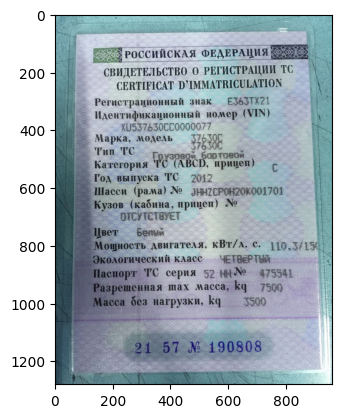

In [521]:
path = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_2157_190808-1.png'
img = cv2.imread(path)

plt.imshow(img)

In [ ]:
# type_, conf, rect = yolo_predict(model, path)[0]
# cropped = crop_image(img, rect)
# res = ocr(cropped)

In [522]:
%%time
work(path)


image 1/1 /kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS/s_2157_190808-1.png: 640x480 1 sts_front, 28.1ms
Speed: 2.3ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
CPU times: user 8.26 s, sys: 646 ms, total: 8.91 s
Wall time: 8.65 s


[{'type': 'vehicle_certificate',
  'confidence': 0.9657411,
  'series': '2157',
  'number': '190808',
  'page_number': 1}]